In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [10]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [11]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Temperature/Rangpur.csv')
#the daily dataset
print(df.shape)
df.head()

(720, 4)


,DATE,Max Temp,Min Temp,MEAN
0,1/31/1954,26.589474,10.575439,18.582456
1,2/28/1954,29.722807,12.826316,21.274561
2,3/31/1954,34.859649,16.721053,25.790351
3,4/30/1954,36.454386,20.887719,28.671053
4,5/31/1954,36.089474,23.010526,29.550000


In [12]:
#checking types
df.pop('Max Temp')
df.pop('Min Temp')
df.dtypes

DATE     object
MEAN    float64
dtype: object

Data Preprocessing
---------

In [13]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

           DATE       MEAN
0     1/31/1954  18.582456
1     2/28/1954  21.274561
2     3/31/1954  25.790351
3     4/30/1954  28.671053
4     5/31/1954  29.550000
..          ...        ...
715   8/31/2013  31.100000
716   9/30/2013  30.800000
717  10/31/2013  28.300000
718  11/30/2013  23.350000
719  12/31/2013  21.200000

[720 rows x 2 columns]


In [14]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [15]:
df.head()

,DATE,MEAN
0,1/31/1954,18.582456
1,2/28/1954,21.274561
2,3/31/1954,25.790351
3,4/30/1954,28.671053
4,5/31/1954,29.550000


In [16]:
df.tail()

,DATE,MEAN
715,8/31/2013,31.10
716,9/30/2013,30.80
717,10/31/2013,28.30
718,11/30/2013,23.35
719,12/31/2013,21.20


In [17]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
#df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,MEAN
DATE,
1/31/1954,18.582456
2/28/1954,21.274561
3/31/1954,25.790351
4/30/1954,28.671053
5/31/1954,29.550000


In [18]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Rangpur_monthly.csv")

(720, 1)


In [19]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1954-01-31 00:00:00
End Date: 2013-12-31 00:00:00
Total month: 720
Total year: 60


Data Visulalization
----------

About Data

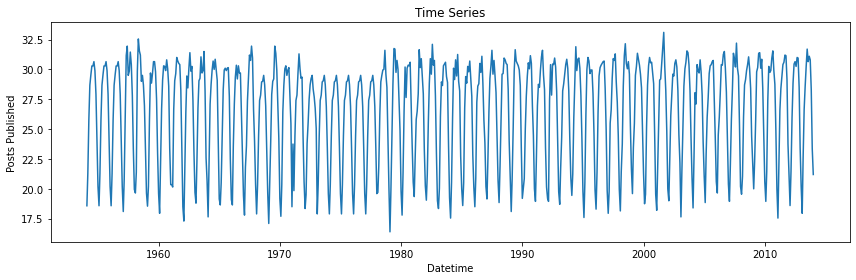

In [20]:
# 7.Plotting the time series
monthly['MEAN'] = monthly['MEAN'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(624, 1), Validation=(96, 1)


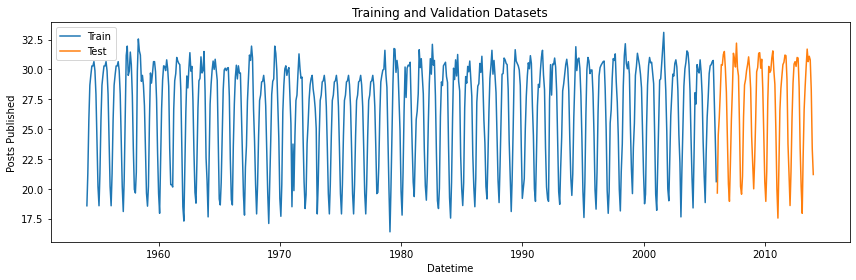

In [21]:
train = monthly.loc[:'2005-12-31']
valid = monthly.loc['2006-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [22]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [23]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

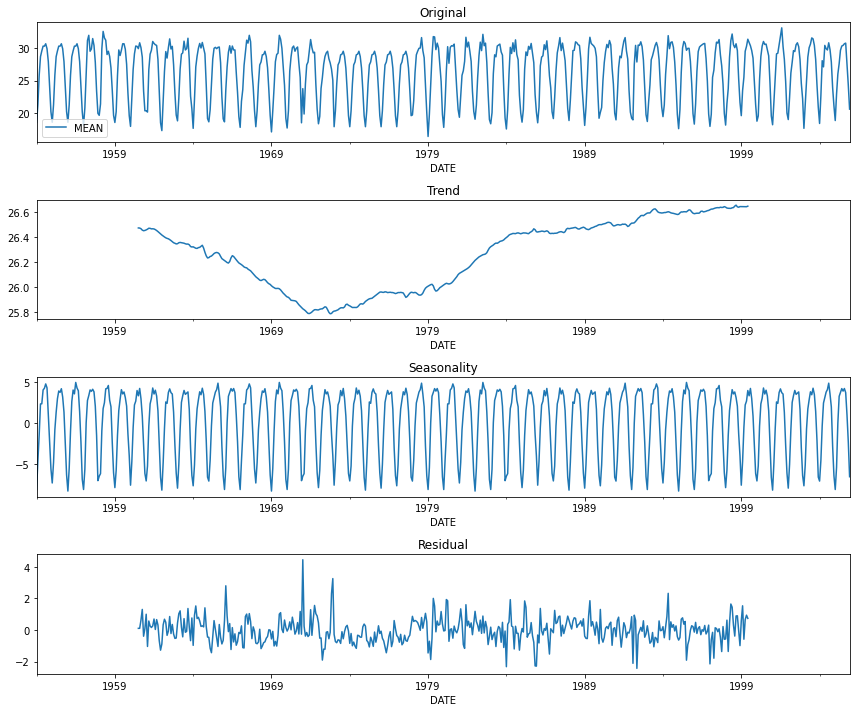

In [24]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [25]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

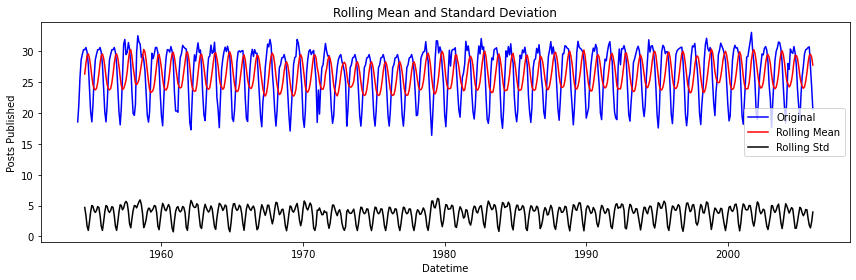

Results of Dickey-Fuller Test:
Test Statistic                  -3.598264
P-Value                          0.005794
#Lags Used                      13.000000
Number of Observations Used    610.000000
Critical Value (1%)             -3.441116
Critical Value (5%)             -2.866290
Critical Value (10%)            -2.569300
dtype: float64


In [26]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [27]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [28]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   MEAN   No. Observations:                  624
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1049.613
Date:                Mon, 07 Nov 2022   AIC                           2117.226
Time:                        09:23:29   BIC                           2157.137
Sample:                    01-31-1954   HQIC                          2132.736
                         - 12-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7758      0.031     25.083      0.000       0.715       0.836
ar.L2         -0.2187      0.037     -5.954      0.000      -0.291      -0.147
ar.L3         -0.3549      0.044     -8.034      0.0

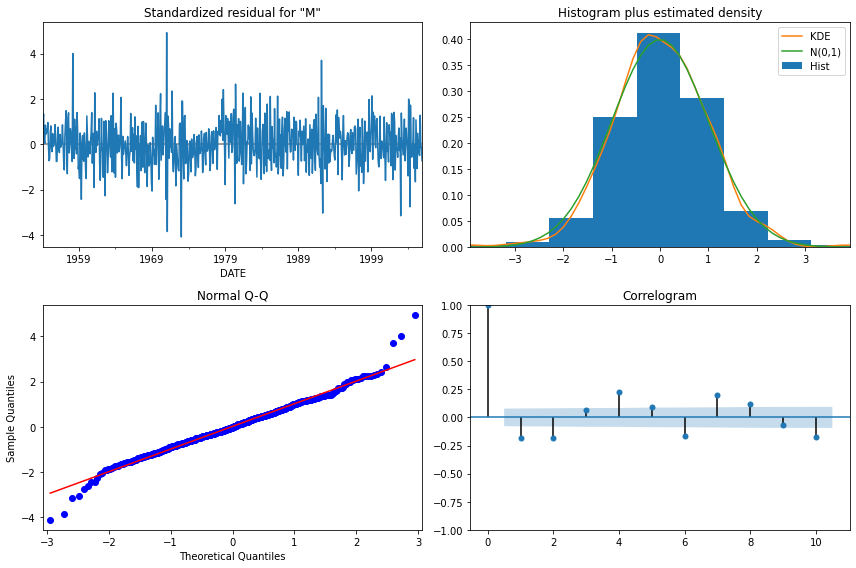

In [29]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

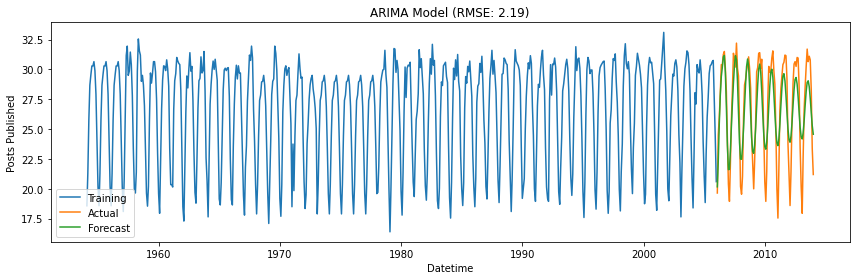

In [30]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [31]:
#Values of ARIMA prediction
print(forecast_arima)

2006-01-31    20.169732
2006-02-28    22.286059
2006-03-31    25.448981
2006-04-30    27.787927
2006-05-31    29.398592
                ...    
2013-08-31    28.556964
2013-09-30    27.582505
2013-10-31    26.386000
2013-11-30    25.284232
2013-12-31    24.568812
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [32]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  2.1926667918178233


---------------------

SARIMAX MODEL

In [33]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [34]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                               MEAN   No. Observations:                  624
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                -815.411
Date:                            Mon, 07 Nov 2022   AIC                           1664.823
Time:                                    09:27:03   BIC                           1739.879
Sample:                                01-31-1954   HQIC                          1694.017
                                     - 12-31-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2355      0.031      7.602      0.000       0.175       0.296
ar.L2          0.0299      0.039   

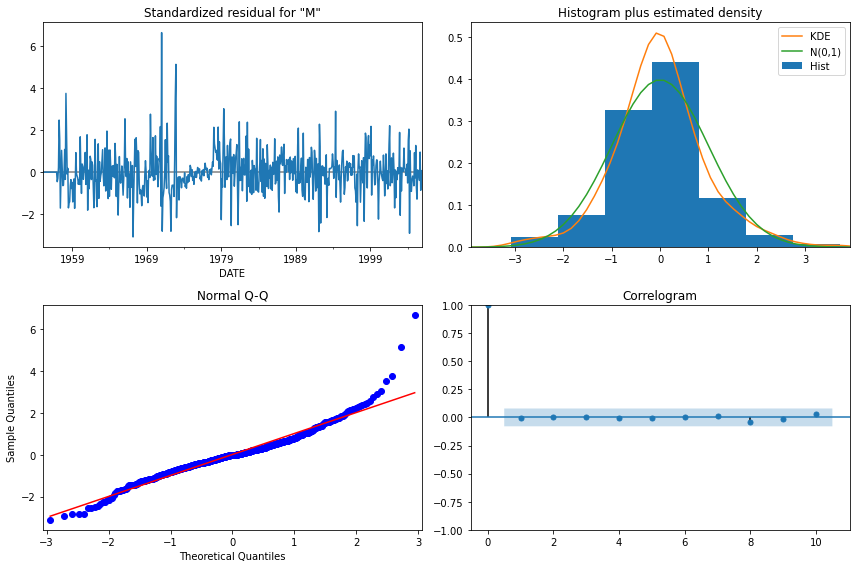

In [35]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

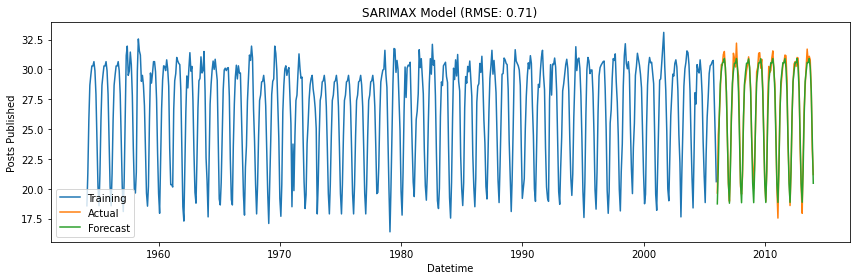

In [36]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [37]:
#Value of SARIMA prediction
print(forecast_sarimax)

2006-01-31    18.741092
2006-02-28    21.654188
2006-03-31    25.971967
2006-04-30    28.773934
2006-05-31    29.812078
                ...    
2013-08-31    30.913217
2013-09-30    30.151437
2013-10-31    28.148711
2013-11-30    24.292835
2013-12-31    20.468361
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [38]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.7063138404941974


-----------------------

PROPHET

In [39]:
#Reading monthly data 
df= pd.read_csv('Rangpur_monthly.csv')

In [40]:

#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1954-01-31,18.582456
1,1954-02-28,21.274561
2,1954-03-31,25.790351
3,1954-04-30,28.671053
4,1954-05-31,29.550000


In [41]:
#prophet model Implement
prophet_model = Prophet()

In [42]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfa_nvu1s/fhbaiv37.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfa_nvu1s/uuw85_o9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54543', 'data', 'file=/tmp/tmpfa_nvu1s/fhbaiv37.json', 'init=/tmp/tmpfa_nvu1s/uuw85_o9.json', 'output', 'file=/tmp/tmpfa_nvu1s/prophet_modeli2jhyuj7/prophet_model-20221107092705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:27:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:27:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [43]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 11, freq='M')
print(prophet_forecast_date)

            ds
0   1954-01-31
1   1954-02-28
2   1954-03-31
3   1954-04-30
4   1954-05-31
..         ...
847 2024-08-31
848 2024-09-30
849 2024-10-31
850 2024-11-30
851 2024-12-31

[852 rows x 1 columns]


In [44]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1954-01-31,26.672046,17.754003,20.031976,26.672046,26.672046,-7.779461,-7.779461,-7.779461,-7.779461,-7.779461,-7.779461,0.0,0.0,0.0,18.892585
1,1954-02-28,26.668815,20.422921,22.625961,26.668815,26.668815,-5.058055,-5.058055,-5.058055,-5.058055,-5.058055,-5.058055,0.0,0.0,0.0,21.610760
2,1954-03-31,26.665237,24.861797,27.141725,26.665237,26.665237,-0.657690,-0.657690,-0.657690,-0.657690,-0.657690,-0.657690,0.0,0.0,0.0,26.007547
3,1954-04-30,26.661775,27.811449,30.013936,26.661775,26.661775,2.248518,2.248518,2.248518,2.248518,2.248518,2.248518,0.0,0.0,0.0,28.910293
4,1954-05-31,26.658197,28.761687,30.927792,26.658197,26.658197,3.181094,3.181094,3.181094,3.181094,3.181094,3.181094,0.0,0.0,0.0,29.839291


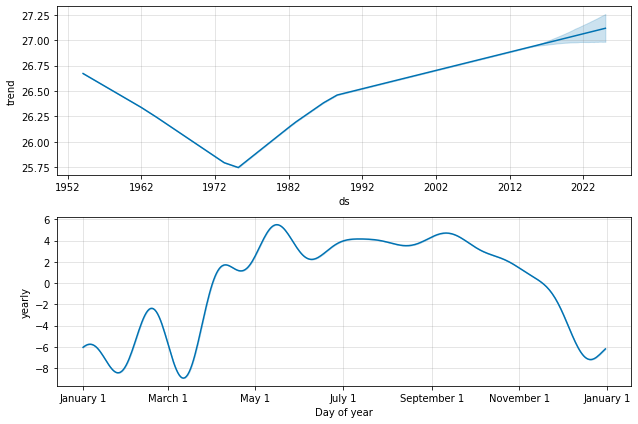

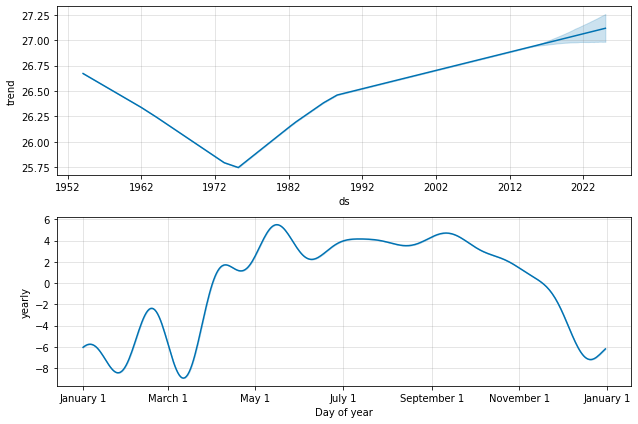

In [45]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [46]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1954-01-31  18.892585
1954-02-28  21.610760
1954-03-31  26.007547
1954-04-30  28.910293
1954-05-31  29.839291
...               ...
2024-08-31  31.393287
2024-09-30  30.577694
2024-10-31  28.602027
2024-11-30  24.603029
2024-12-31  20.969116

[852 rows x 1 columns]


In [47]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1954-01-31    18.892585
1954-02-28    21.610760
1954-03-31    26.007547
1954-04-30    28.910293
1954-05-31    29.839291
                ...    
2024-08-31    31.393287
2024-09-30    30.577694
2024-10-31    28.602027
2024-11-30    24.603029
2024-12-31    20.969116
Name: yhat, Length: 852, dtype: float64


In [48]:
print(valid)

             MEAN
DATE             
2006-01-31  19.65
2006-02-28  24.50
2006-03-31  26.00
2006-04-30  28.00
2006-05-31  30.40
...           ...
2013-08-31  31.10
2013-09-30  30.80
2013-10-31  28.30
2013-11-30  23.35
2013-12-31  21.20

[96 rows x 1 columns]


In [49]:
forecast_prophet_valid=full_forecast_prophet['2006-01-31':'2013-12-31']

In [50]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.6734636093009221


-----------------

MODEL Comparison
----------

Testing

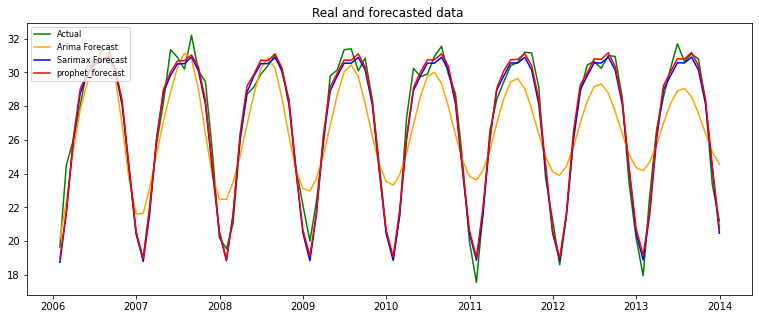

In [51]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

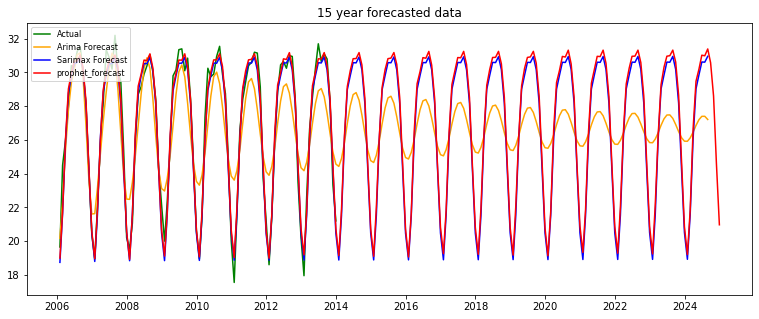

In [52]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+128)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+128)
forecast_10_prophet=full_forecast_prophet['2006-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

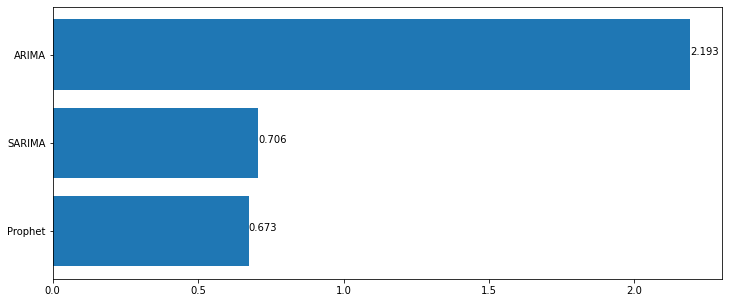

In [53]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [54]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2019-12-31

Great! Now choose the model result you want to see for 2019-12-31
 1.Arima 
 2.Sarimax
 3.Prophet
 2
Choosen Model is Sarimax
In 2019-12-31 rainfall value for Sarimax model:  20.490834667496312


In [55]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Rangpur-monthly_merged.csv")